In [223]:
import random
from datetime import datetime


In [224]:
import torch
from torch import nn

In [225]:
from utils_random import set_random_seed
from utils_torch.data import stratified_random_split
from utils_torch.modules import get_seq_size_out
from utils_attacker_lstm.data import DatasetAttackerLSTMPool, DataLoaderAttackerLSTM
from utils_attacker_lstm.models import ModelAttackerLSTM, TrainerAttackerLSTM, TesterAttackerLSTM, \
    ManagerAttackerLSTM
from utils_plot import plot_train_eval_loss_accuracy, plot_receiver_operating_characteristics_curve, \
    plot_confusion_matrix, plot_long_short_term_memory

In [226]:
model_id = datetime.now().strftime("%m%d%H%M")

In [227]:
random_seed = random.randint(0, 2 ** 32 - 1)

In [228]:
set_random_seed(random_seed)

In [229]:
num_snps = random.choice([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
train_eval_test_split = [0.7, 0.15, 0.15]

In [230]:
genome_batch_size = random.randint(16, 64)
snp_batch_size = num_snps

In [231]:
found = False
while not found:
    conv_num_layers = random.randint(1, 8)
    conv_channel_size = [3] + [random.randint(16, 64) for _ in range(conv_num_layers)]
    conv_kernel_size = [random.randint(4, 32) for _ in range(conv_num_layers)]
    conv_stride = [random.randint(1, conv_kernel_size[i]) for i in range(conv_num_layers)]
    conv_dilation = [random.randint(1, 4) for _ in range(conv_num_layers)]
    conv_groups = [1 for _ in range(conv_num_layers)]

    found = True
    sequence_size = num_snps
    for i in range(conv_num_layers):
        sequence_size = get_seq_size_out(seq_size_in=sequence_size,
                                         kernel_size=conv_kernel_size[i],
                                         stride=conv_stride[i],
                                         padding=0,
                                         dilation=conv_dilation[i])
        if sequence_size < conv_kernel_size[i]:
            found = False
            break

conv_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
conv_activation_kwargs = {}

conv_dropout_p = [random.uniform(0, 0.66) for _ in range(conv_num_layers - 1)]
conv_dropout_first = [random.choice([True, False]) for _ in range(conv_num_layers - 1)]

conv_batch_norm = [random.choice([True, False]) for _ in range(conv_num_layers - 1)]
conv_batch_norm_momentum = [random.uniform(0, 1) for _ in range(conv_num_layers - 1)]

In [232]:
conv_lstm_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
conv_lstm_activation_kwargs = {}

conv_lstm_dropout_p = random.uniform(0, 0.66)
conv_lstm_dropout_first = random.choice([True, False])

conv_lstm_layer_norm = random.choice([True, False])

In [233]:
lstm_num_layers = random.randint(1, 4)
lstm_input_size = conv_channel_size[-1]
lstm_hidden_size = [random.randint(4, 64) for _ in range(lstm_num_layers)]
lstm_proj_size = [0 for _ in range(lstm_num_layers)]
lstm_bidirectional = [random.choice([True, False]) for _ in range(lstm_num_layers)]

lstm_dropout_p = [random.uniform(0, 0.66) for _ in range(lstm_num_layers - 1)]
lstm_dropout_first = [random.choice([True, False]) for _ in range(lstm_num_layers - 1)]

lstm_layer_norm = [random.choice([True, False]) for _ in range(lstm_num_layers - 1)]

In [234]:
lstm_linear_dropout_p = random.uniform(0, 0.66)
lstm_linear_dropout_first = random.choice([True, False])

lstm_linear_batch_norm = random.choice([True, False])
lstm_linear_batch_norm_momentum = random.uniform(0, 1)

In [235]:
linear_num_layers = random.randint(1, 4)
linear_num_features = [lstm_hidden_size[-1] * (2 if any(lstm_bidirectional) else 1)] + [random.randint(4, 64) for _ in
                                                                                        range(
                                                                                            linear_num_layers - 1)] + [
                          1]

linear_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
linear_activation_kwargs = {}

linear_dropout_p = [random.uniform(0, 0.66) for _ in range(linear_num_layers - 1)]
linear_dropout_first = [random.choice([True, False]) for _ in range(linear_num_layers - 1)]

linear_batch_norm = [random.choice([True, False]) for _ in range(linear_num_layers - 1)]
linear_batch_norm_momentum = [random.uniform(0, 1) for _ in range(linear_num_layers - 1)]

In [236]:
num_epochs = 256
learning_rate = 0.001

In [237]:
models_dir = "../models"
models_file = "models.csv"
plots_dir = "../plots"

In [238]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [239]:
dataset = DatasetAttackerLSTMPool(
    genomes_pool_path="../data/test/In_Pop.pkl",
    genomes_reference_path="../data/test/Not_In_Pop.pkl",
    num_snps=num_snps)
subset_train, subset_eval, subset_test = stratified_random_split(dataset=dataset,
                                                                 ratios=train_eval_test_split)

In [240]:
dataloader_train = DataLoaderAttackerLSTM(
    dataset=subset_train,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=True)
dataloader_eval = DataLoaderAttackerLSTM(
    dataset=subset_eval,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=False)
dataloader_test = DataLoaderAttackerLSTM(
    dataset=subset_test,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=False)

In [244]:
model = ModelAttackerLSTM(
    conv_num_layers=conv_num_layers,
    conv_channel_size=conv_channel_size,
    conv_kernel_size=conv_kernel_size,
    conv_stride=conv_stride,
    conv_dilation=conv_dilation,
    conv_groups=conv_groups,
    conv_activation=conv_activation,
    conv_activation_kwargs=conv_activation_kwargs,
    conv_dropout_p=conv_dropout_p,
    conv_dropout_first=conv_dropout_first,
    conv_batch_norm=conv_batch_norm,
    conv_batch_norm_momentum=conv_batch_norm_momentum,
    conv_lstm_activation=conv_lstm_activation,
    conv_lstm_activation_kwargs=conv_lstm_activation_kwargs,
    conv_lstm_dropout_p=conv_lstm_dropout_p,
    conv_lstm_dropout_first=conv_lstm_dropout_first,
    conv_lstm_layer_norm=conv_lstm_layer_norm,
    lstm_num_layers=lstm_num_layers,
    lstm_input_size=lstm_input_size,
    lstm_hidden_size=lstm_hidden_size,
    lstm_proj_size=lstm_proj_size,
    lstm_bidirectional=lstm_bidirectional,
    lstm_dropout_p=lstm_dropout_p,
    lstm_dropout_first=lstm_dropout_first,
    lstm_layer_norm=lstm_layer_norm,
    lstm_linear_dropout_p=lstm_linear_dropout_p,
    lstm_linear_dropout_first=lstm_linear_dropout_first,
    lstm_linear_batch_norm=lstm_linear_batch_norm,
    lstm_linear_batch_norm_momentum=lstm_linear_batch_norm_momentum,
    linear_num_layers=linear_num_layers,
    linear_num_features=linear_num_features,
    linear_activation=linear_activation,
    linear_activation_kwargs=linear_activation_kwargs,
    linear_dropout_p=linear_dropout_p,
    linear_dropout_first=linear_dropout_first,
    linear_batch_norm=linear_batch_norm,
    linear_batch_norm_momentum=linear_batch_norm_momentum)
model.to(device)

AssertionError: lstm_output_size_out must be equal to linear_num_features_in

In [190]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)
scheduler = None

In [191]:
trainer = TrainerAttackerLSTM(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=dataloader_train,
    eval_loader=dataloader_eval,
    device=device,
    max_grad_norm=1.0,
    norm_type=2)

In [192]:
tester = TesterAttackerLSTM(
    model=model,
    criterion=criterion,
    test_loader=dataloader_test,
    device=device)

In [193]:
manager = ManagerAttackerLSTM(
    models_dir=models_dir,
    models_file=models_file)

In [194]:
trainer.train(num_epochs=num_epochs,
              verbose=True)

Epoch 1/256
Train Loss: 0.7536, Train Accuracy: 0.51
Evaluation Loss: 0.6989, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: inf -> 0.6989. Saving Model...
Epoch 2/256
Train Loss: 0.7260, Train Accuracy: 0.53
Evaluation Loss: 0.6948, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: 0.6989 -> 0.6948. Saving Model...
Epoch 3/256
Train Loss: 0.7532, Train Accuracy: 0.48
Evaluation Loss: 0.6955, Evaluation Accuracy: 0.50
Epoch 4/256
Train Loss: 0.7288, Train Accuracy: 0.49
Evaluation Loss: 0.6928, Evaluation Accuracy: 0.52
Evaluation Loss Decreased: 0.6948 -> 0.6928. Saving Model...
Epoch 5/256
Train Loss: 0.7113, Train Accuracy: 0.53
Evaluation Loss: 0.6965, Evaluation Accuracy: 0.50
Epoch 6/256
Train Loss: 0.7223, Train Accuracy: 0.49
Evaluation Loss: 0.6955, Evaluation Accuracy: 0.50
Epoch 7/256
Train Loss: 0.7298, Train Accuracy: 0.47
Evaluation Loss: 0.6938, Evaluation Accuracy: 0.50
Epoch 8/256
Train Loss: 0.7041, Train Accuracy: 0.51
Evaluation Loss: 0.6930, Evaluation Acc

In [195]:
finish_time = datetime.now()
best_eval_loss_epoch = trainer.best_eval_loss_epoch
best_eval_loss = trainer.best_eval_loss
best_eval_accuracy = trainer.eval_accuracies[best_eval_loss_epoch]

print(f'Finished training at {finish_time}')
print(f'Best evaluation loss epoch found at: {best_eval_loss_epoch}')
print(f'Best evaluation loss found: {best_eval_loss:.4f}')
print(f'Best evaluation accuracy found: {best_eval_accuracy:.4f}')

Finished training at 2024-12-05 08:00:06.706710
Best evaluation loss epoch found at: 174
Best evaluation loss found: 0.6922
Best evaluation accuracy found: 0.5417


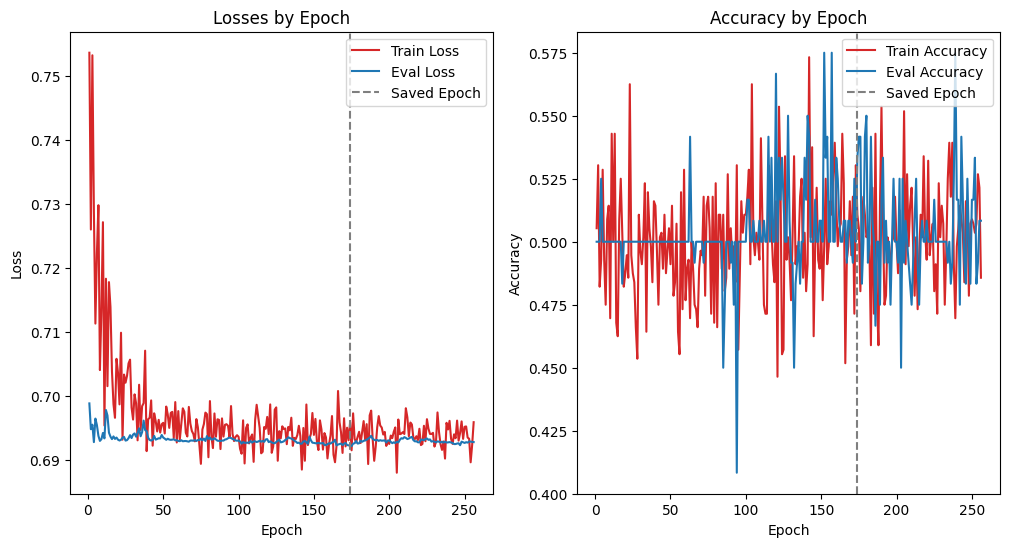

In [196]:
plot_train_eval_loss_accuracy(train_loss=trainer.train_losses,
                              train_accuracy=trainer.train_accuracies,
                              eval_loss=trainer.eval_losses,
                              eval_accuracy=trainer.eval_accuracies,
                              saved_epoch=best_eval_loss_epoch,
                              output_path=plots_dir,
                              output_file=f"model_attacker_pool_{model_id}_train_eval_loss_acc.png")

In [197]:
tester.test()

In [198]:
print(f'Test loss: {tester.loss:.4f}')
print(f'Test accuracy: {tester.accuracy_score:.2f}')
print(f'Test precision: {tester.precision_score:.2f}')
print(f'Test recall: {tester.recall_score:.2f}')
print(f'Test f1: {tester.f1_score:.2f}')
print(f'Test AUC: {tester.auroc_score:.2f}')

Test loss: 0.6926
Test accuracy: 0.52
Test precision: 0.52
Test recall: 0.58
Test f1: 0.55
Test AUC: 0.52


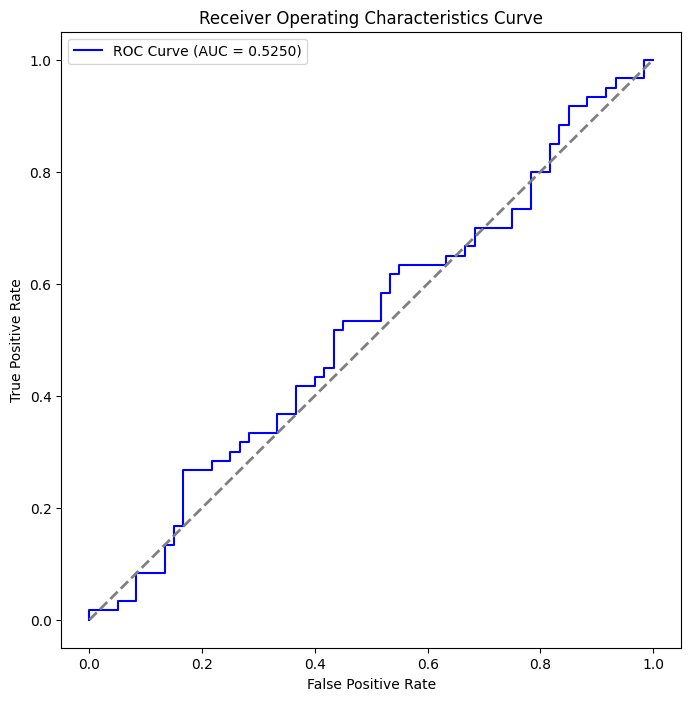

In [199]:
fpr, tpr, _ = tester.roc_curve
plot_receiver_operating_characteristics_curve(false_positive_rates=fpr,
                                              true_positive_rates=tpr,
                                              auc=tester.auroc_score,
                                              output_path=plots_dir,
                                              output_file=f"model_attacker_pool_{model_id}_roc_curve.png")

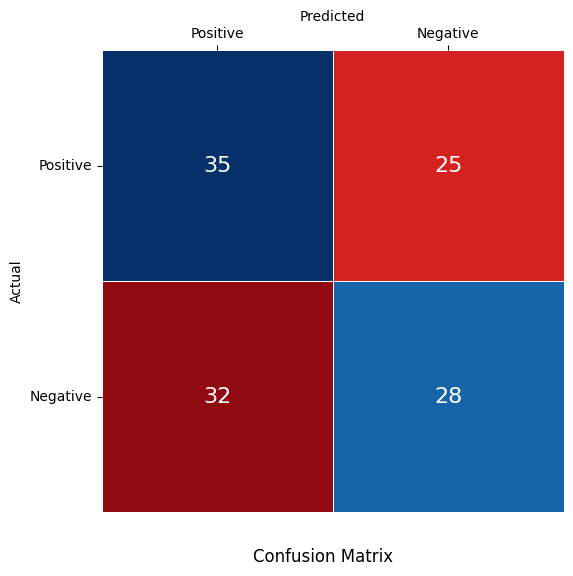

In [200]:
plot_confusion_matrix(confusion_matrix=tester.confusion_matrix_scores,
                      task="binary",
                      output_path=plots_dir,
                      output_file=f"model_attacker_pool_{model_id}_confusion_matrix.png")

In [201]:
manager.add_model(
    model_id=model_id,
    random_seed=random_seed,
    data=dataset,
    loader=dataloader_train,
    model=model,
    trainer=trainer,
    tester=tester)

In [202]:
model.set_hidden_cell_mode(True)
model.eval()
with torch.no_grad():
    x, y = dataloader_test.dataset[0]
    x = x.unsqueeze(0).to(device)
    hx = None
    logits, out = model.forward(x, hx)
out_last = out[-1]
(h, c), (h_last, c_last) = out_last
h, c = h.squeeze(0), c.squeeze(0)

C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


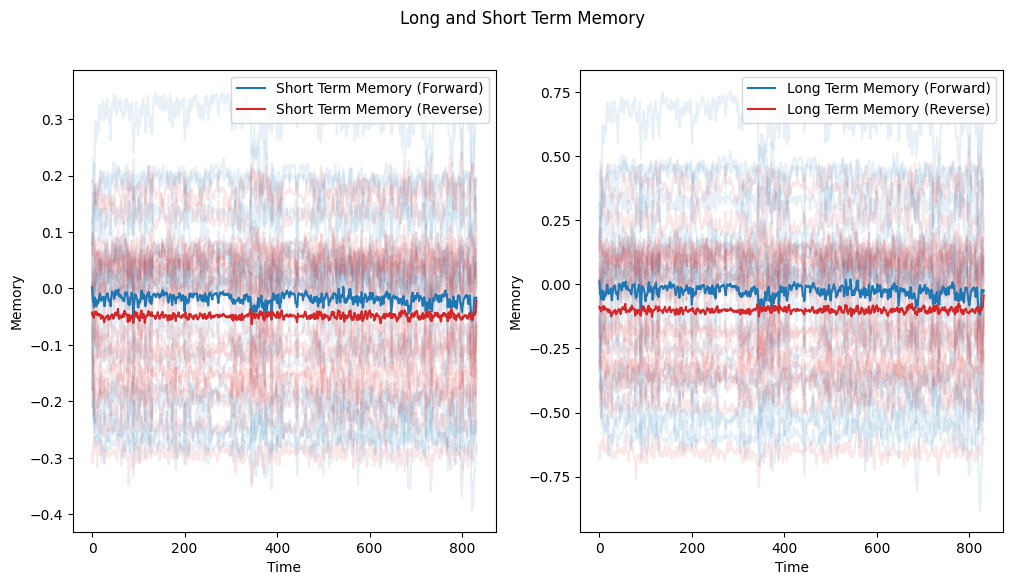

In [203]:
plot_long_short_term_memory(long_term_memory=c.cpu(),
                            short_term_memory=h.cpu(),
                            bidirectional=lstm_bidirectional[-1],
                            output_path=plots_dir,
                            output_file=f"model_attacker_pool_{model_id}_lstm.png")